# Measuring Controversy in Twitter threads

We follow the paper of Guerra et al. (2020), as we try to identify ways to measure controversy/polarization in a twitter conversation represented as a graph, where the nodes are the tweets and the edges are the users. 

See:  
Guerra, P., Meira Jr., W., Cardie, C., & Kleinberg, R. (2013, June 28). A Measure of Polarization on Social Media Networks Based on Community Boundaries. Proceedings of the International AAAI Conference on Web and Social Media; AAAI Publications.[Link](https://ojs.aaai.org/index.php/ICWSM/article/view/14421)

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

Some code references to make graph objects out of Twitter threads:

* "[Analysis of Twitter](https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb)" by Eugenia Inzaugarat

In [70]:
data = pd.read_json('tweets1.json', lines=True)

In [71]:
user_all =[]
data['user_id'] = None
data['user_name'] = None
for i in range(len(data)):
    user_data = data.user.iloc[i]
    user_all.append(user_data)
    data['user_id'].iloc[i] = int(user_data['id'])
    data['user_name'].iloc[i] = user_data['username']
    

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [72]:
user_all = pd.DataFrame(user_all)

In [73]:
tweets = data[['date', 'content', 'id', 'user_id', 'user_name','mentionedUsers', 
               'conversationId']]
tweets_final = tweets.where((pd.notnull(tweets)), None)
tweets_final = tweets[pd.notna(tweets['mentionedUsers'])]

## 1. Graph Building Phase

In [74]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = (int(row["user_id"]), row["user_name"])
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    for user_reply in row['mentionedUsers']:
        user_reply_name = user_reply['username']
        user_reply_id = int(user_reply['id'])
        interactions.add((user_reply_id, user_reply_name))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["user_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [75]:
graph = nx.Graph()
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id = user[0]
    user_name = user[1]
    tweet_id = tweet["id"]
    is_thread = True if len(interactions) > 3 else False
    
    for interaction in interactions:
        int_id = interaction[0]
        int_name = interaction[1]
        graph.add_edge(int(user_id), int(int_id), tweet_id=int(tweet_id))
        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name

In [76]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 593 nodes and 953 edges present in the Graph


In [77]:
degrees = [val for (node, val) in graph.degree()]

In [78]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The maximum degree of the Graph is 563
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 3.2
The most frequent degree of the nodes found in the Graph is 1


In [79]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected


In [80]:
largest_subgraph = max(nx.connected_components(graph), key=len)

In [81]:
node_and_degree = graph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = ['393852070', '2896294831']

In [82]:
pos = nx.spring_layout(graph, k=0.05)

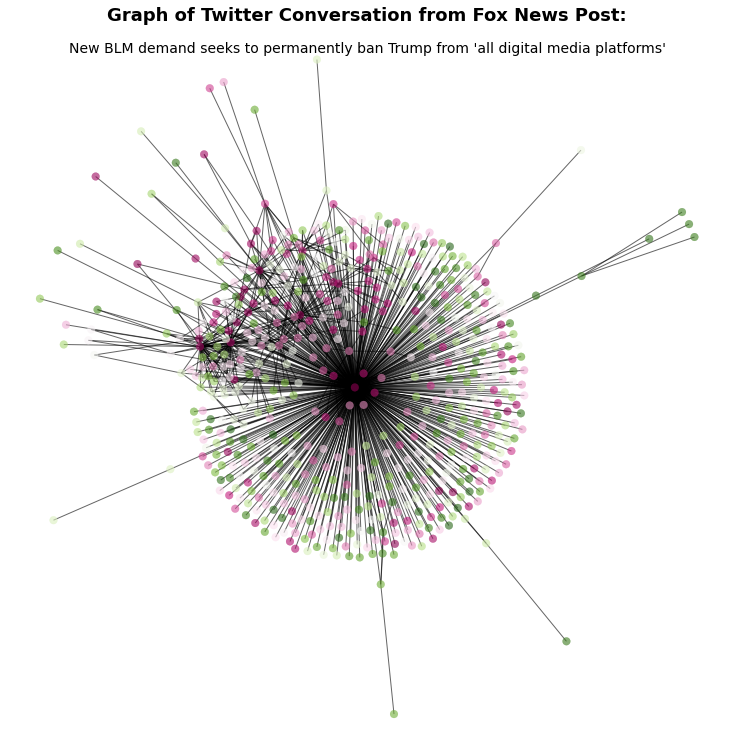

In [83]:
plt.figure(figsize = (10,10))
nx.draw(graph, pos=pos, 
        node_color=range(graph.number_of_nodes()), 
        cmap=plt.cm.PiYG, edge_color="black",
        linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
plt.title("Graph of Twitter Conversation from Fox News Post:", fontsize=18,
         fontweight="bold")
plt.suptitle("New BLM demand seeks to permanently \
ban Trump from 'all digital media platforms'", fontsize=14)
plt.show()

## 2. Community Identification Phase
To identify the jargon of the community we need to be very accurate at defining its members.
We cluster using Louvain, a graph-clustering algorithm, and take the two biggest communities.

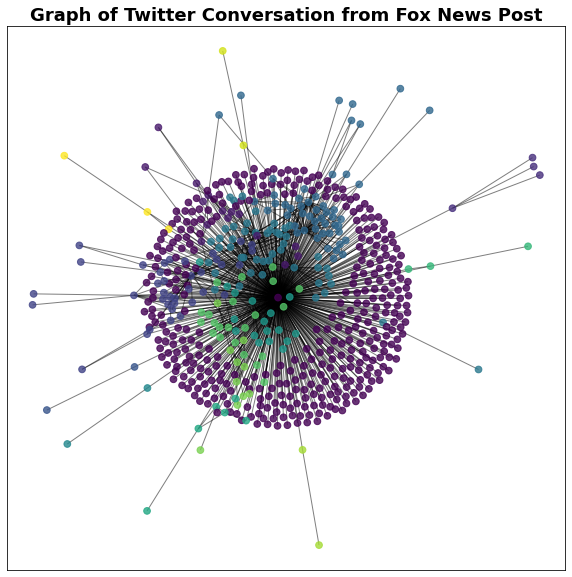

In [84]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt


plt.figure(figsize = (10,10))

# compute the best partition
partition = community_louvain.best_partition(graph, random_state=0)

# draw the graph
pos = nx.spring_layout(graph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=45,alpha=0.8,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.5)

#plt.suptitle("New BLM demand seeks to permanently \
#ban Trump from 'all digital media platforms'", fontsize=14)

plt.title("Graph of Twitter Conversation from Fox News Post", fontsize=18,
         fontweight="bold")

plt.show()

In [85]:
set(partition.values())
#communities 12, 1

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [86]:
dendogram = community_louvain.generate_dendrogram(graph, random_state=0)


In [87]:
dendogram[len(dendogram)-1]

{16: 0,
 0: 1,
 14: 6,
 5: 3,
 6: 4,
 9: 5,
 11: 8,
 13: 11,
 7: 8,
 8: 6,
 12: 10,
 17: 11,
 2: 12,
 1: 13,
 3: 14,
 4: 15,
 10: 9,
 18: 2,
 15: 7}

## 3. Embedding Phase

In this phase, each user is embeded into a corresponding vector. These vectors encode syntactic and semantic proprieties of the posts of the corresponding accounts. 


Firstly, tweets belonging to the users of the two principal communities selected in the previous stage are grouped by user and sanitized.

We train this model with tagged data, accordingly to the output of Louvain (previous stage), representing the community of the user.



100%|██████████| 2000/2000 [00:07<00:00, 250.93it/s]


BarnesHut Approximation  took  1.95  seconds
Repulsion forces  took  5.32  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


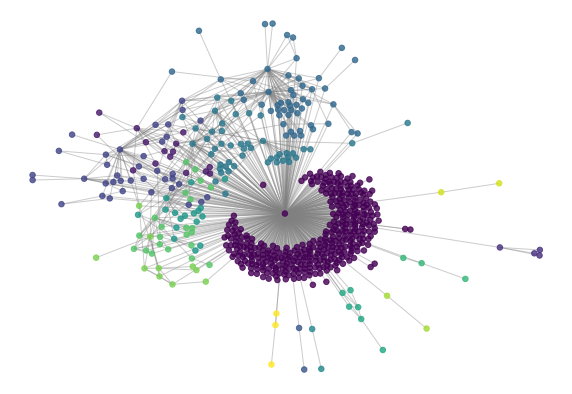

In [88]:
import networkx as nx
from fa2 import ForceAtlas2
%matplotlib inline
plt.figure(figsize=(10,7))

forceatlas2 = ForceAtlas2()
positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=pos, iterations=2000)
nx.draw_networkx_nodes(graph, positions,partition.keys(), node_size=30,alpha=0.8,
                       cmap=cmap, node_color=list(partition.values()))

nx.draw_networkx_edges(graph, positions, edge_color="grey", alpha=0.4)
plt.axis('off')
plt.show()

## 4. Controversy Score Computation Phase